# Downloading and preprocessesing GIS data

Download data about POI in Allegheny County from WPRDC.

Link to data: https://data.wprdc.org/dataset/allegheny-county-assets/resource/5c7825d2-6814-40c7-aefe-3d0f3d6f22e7?view_id=7e2a0120-4325-4fde-99de-e56c22c2b561

### Import packages

In [1]:
import os
import gc
from multiprocessing import Pool
import warnings
warnings.filterwarnings(action="ignore")

from keras.utils import get_file
from tqdm.notebook import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# for multiprocessing
import multiprocessor_gis

Define constants.

- ``PATH``: Path to the base data folder
- ``COORD_RANGE_LAT``: latitude coordinate range of Allegheny County
- ``COORD_RANGE_LONG``: longitude coordinate range of Allegheny County
- ``CPU_CORES``: how many cpu cores to use, default = all
- ``MAX_DIST_DUP``: maximum distance for duplicate detection
- ``COUNT_RADIUS``: maximum distance for _count features

In [2]:
PATH = "C:/Users/Tim/.keras/datasets/wikipedia_real_estate/"
COORD_RANGE_LAT = (40.000000, 40.870000)
COORD_RANGE_LONG = (-80.550000, -79.500000)
# CPU_CORES = os.cpu_count()
CPU_CORES = 11
MAX_DIST_DUP = 10  # in meters
COUNT_RADIUS = 3500  # in meters

Download data. If already downloaded, load data.

In [3]:
f_path = get_file(PATH + "wprdc/gis_data.csv", "https://tools.wprdc.org/downstream/5c7825d2-6814-40c7-aefe-3d0f3d6f22e7")

In [4]:
gis_df = pd.read_csv(f_path)
print(gis_df.shape)
gis_df.head(10)

(2678978, 45)


,_id,name,asset_type,tags,location_id,street_address,unit,unit_type,municipality,city,...,localizability,services,hard_to_count_population,data_source_names,data_source_urls,organization_name,organization_phone,organization_email,etl_notes,geocoding_properties
0,2750,Medical Center Clinic,doctors_offices,NaN,17333.0,"4185 Friendship Avenue, Suite 340",NaN,NaN,NaN,Pittsburgh,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
1,2936,Pie Traynor Field Concession Stand,parks_and_facilities,NaN,88619.0,NaN,NaN,NaN,NaN,NaN,...,FIX,NaN,NaN,WPRDC Dataset: Allegheny County Park Facilities,https://data.wprdc.org/dataset/allegheny-count...,Allegheny County Parks Department,NaN,NaN,NaN,NaN
2,2751,Medical Center Clinic,doctors_offices,NaN,17534.0,"9930 Grubbs Road, Suite 200",NaN,NaN,NaN,Wexford,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
3,2752,Medi Help,doctors_offices,NaN,17097.0,1691 Washington Road,NaN,NaN,NaN,Mt Lebanon,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
4,2753,Medi Help,doctors_offices,NaN,17397.0,519 Brookline Boulevard,NaN,NaN,NaN,Pittsburgh,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
5,2754,MedExpress Urgent Care PC Pennsylvania,doctors_offices,NaN,17208.0,"2600 Old Washington Road, Suite 150",NaN,NaN,NaN,Upper Saint Clair,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
6,2755,MedExpress Urgent Care PC Pennsylvania,doctors_offices,NaN,17474.0,695 Clairton Boulevard,NaN,NaN,NaN,Pleasant Hills,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
7,2756,MedExpress Urgent Care PC Pennsylvania,doctors_offices,NaN,17075.0,1535 Washington Road,NaN,NaN,NaN,Pittsburgh,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN
8,21142,PITTSBURGH TECHNICAL INSTITUTE - PTI,universities,NaN,89102.0,NaN,NaN,NaN,NaN,NaN,...,FIX,NaN,NaN,Southwestern Pennsylvania Commission: Universi...,https://spcgis-spc.hub.arcgis.com/datasets/uni...,NaN,NaN,NaN,PTI,NaN
9,2757,MedExpress Urgent Care PC Pennsylvania,doctors_offices,NaN,17285.0,3516 Saw Mill Run Boulevard,NaN,NaN,NaN,Pittsburgh,...,FIX,NaN,NaN,WPRDC Data: Primary Care Access 2014 Data,https://data.wprdc.org/dataset/allegheny-count...,NaN,NaN,NaN,NaN,NaN


As can be seen in the summary, some coordinates are very far outside of Allegheny county and need to be filtered.

In [5]:
gis_df.loc[:,"latitude":"longitude"].describe().loc["mean":,:]

,latitude,longitude
mean,40.465923,-80.008248
std,0.291719,2.296488
min,38.911183,-121.748900
25%,40.404716,-80.027068
50%,40.446569,-79.976947
75%,40.478684,-79.891956
max,45.383687,-73.318068


In [6]:
# filter valid latitude and longitude
rows_before = gis_df.shape[0]
gis_df = gis_df[(gis_df["latitude"] > COORD_RANGE_LAT[0]) & (gis_df["latitude"] < COORD_RANGE_LAT[1])]
gis_df = gis_df[(gis_df["longitude"] > COORD_RANGE_LONG[0]) & (gis_df["longitude"] < COORD_RANGE_LONG[1])]
print(f"Removed {rows_before - gis_df.shape[0]} rows")

Removed 98121 rows


In [7]:
gis_df.loc[:,"latitude":"longitude"].describe().loc["mean":,:]

,latitude,longitude
mean,40.448372,-79.967611
std,0.076367,0.106941
min,40.010286,-80.475548
25%,40.406282,-80.027421
50%,40.446586,-79.979793
75%,40.476466,-79.897748
max,40.866796,-79.505088


Since the densely populated areas appear as a solid blue color, a heatmap would be more helpful. It seems as though a very large portion of datapoints are all in one bin, making all other bins seem dark.

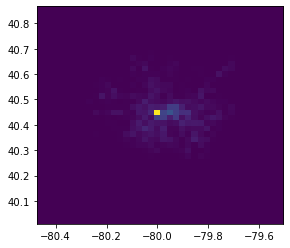

In [8]:
heatmap, xedges, yedges = np.histogram2d(list(gis_df["longitude"]), list(gis_df["latitude"]), bins=40)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

Most of the columns are basically empty.

In [9]:
print(f"Total number of columns: {gis_df.shape[0]}")
gis_df.isna().sum().sort_values(ascending=False)

Total number of columns: 2580857


internet_access               2580857
iffy_geocoding                2580857
unit                          2580857
hard_to_count_population      2580857
services                      2580857
unit_type                     2580857
holiday_hours_of_operation    2580857
parent_location_id            2580857
parent_location               2580857
open_to_public                2580857
wifi_network                  2580857
municipality                  2580776
available_transportation      2580774
organization_phone            2580209
do_not_display                2577455
hours_of_operation            2566597
periodicity                   2560538
computers_available           2551626
accessibility                 2543906
organization_email            2535659
residence                     2525519
child_friendly                2513070
email                         2507938
url                           2503505
tags                          2427394
organization_name             2402250
parcel_id   

Luckily, we only need asset_type and coordinates anyway.

In [10]:
gis_df = gis_df[["_id", "name", "asset_type", "latitude", "longitude"]]

Remove rows without coordinates, since they have no use for us.

In [11]:
gis_df = gis_df.dropna()
gis_df.shape

(2580857, 5)

The data set owner indicated that there might be duplicate entries in the data. To remove duplicates, we remove rows with duplicate coordinates.

In [12]:
rows_before = gis_df.shape[0]
print(f"Shape before: {rows_before}")
gis_df = gis_df.drop_duplicates(subset=["latitude", "longitude"])
print(f"Shape after: {gis_df.shape[0]}")
print(f"Removed {rows_before - gis_df.shape[0]} rows")

Shape before: 2580857
Shape after: 24740
Removed 2556117 rows


There are still duplicates in the data, where the latitude and longitude are just slightly different. We remove those by filtering for only POI which have no other POI of the same category in an 8m radius.

In [13]:
rows_before = gis_df.shape[0]
gis_df_filtered = multiprocessor_gis.remove_duplicates(gis_df, CPU_CORES)
print(f"{rows_before - gis_df_filtered.shape[0]} Rows have been removed.")


788 Rows have been removed.


Let's see what types the assets of our remaining observations have.

In [14]:
gis_df_filtered["asset_type"].value_counts()

bus_stops                   6732
community_nonprofit_orgs    4817
restaurants                 3076
faith-based_facilities       953
apartment_buildings          908
hair_salons                  815
schools                      775
polling_places               664
parks_and_facilities         569
child_care_centers           537
doctors_offices              530
gas_stations                 411
banks                        351
affordable_housing           261
pharmacies                   255
dentists                     224
nail_salons                  216
public_buildings             190
barbers                      189
bars                         184
hotels                       184
coffee_shops                 114
bike_share_stations          112
nursing_homes                106
wic_vendors                   91
farmers_markets               84
food_banks                    69
laundromats                   65
supermarkets                  62
health_centers                60
libraries 

Since the values of the `asset_type` column will turn into distinct columns later, we now remove columns which would lead to "uninteresting" categories later. We set a threshold of at least 30 observations for this category to be relevant. If we would not set this threshold, an unnecessary amount of features would be created.

In [15]:
to_remove = ["homeless_shelters", "wic_offices", "va_facilities", "acha_community_sites", "achd_clinics",
             "veterans_social_orgs", "rec_centers", "family_support_centers"]
gis_categories = gis_df_filtered[~gis_df_filtered["asset_type"].isin(to_remove)]
print(f"Removed {gis_df_filtered.shape[0]-gis_categories.shape[0]} rows")

Removed 97 rows


Show distribution again after preprocessing.

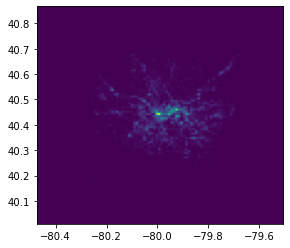

In [16]:
heatmap, xedges, yedges = np.histogram2d(list(gis_df["longitude"]), list(gis_df["latitude"]), bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

plt.clf()
plt.imshow(heatmap.T, extent=extent, origin='lower')
plt.show()

Save GIS df with selected asset types, columns and no duplicates.

In [17]:
gis_categories.to_csv(PATH+"gis_preprocessed.csv", index=False)

## Make feature sets for machine learning

Read structured data.

In [18]:
structured_df = pd.read_csv(PATH+"structured_preprocessed.csv")

Create distance features by calculating distance to nearest POI from every house and counting how many POI there are in a ``COUNT_RADIUS`` radius. See chaper 3.3.2 of thesis for more details.

In [19]:
structured_gis_features = multiprocessor_gis.process_dist_features(gis_categories, structured_df, COUNT_RADIUS, CPU_CORES)
structured_gis_features.head(10)

,_id,PROPERTYZIP,MUNICODE,SCHOOLCODE,NEIGHCODE,LOTAREA,SALEDATE,SALEPRICE,FAIRMARKETTOTAL,STORIES,...,apartment_buildings_dist,apartment_buildings_count,faith-based_facilities_dist,faith-based_facilities_count,restaurants_dist,restaurants_count,community_nonprofit_orgs_dist,community_nonprofit_orgs_count,bus_stops_dist,bus_stops_count
0,427021,15037,908,16,90803,10276,04-21-2017,179900,157200,2,...,1295.71,2,430.854,3,766.162,11,430.131,34,4100.22,0
1,428296,15106,850,7,85002,9375,12-27-2019,185000,180400,1.5,...,1855.1,29,1418.88,23,556.516,79,132.953,140,952.974,193
2,428307,15237,927,27,92705,14827,01-17-2017,226400,167900,1,...,720.787,21,921.939,16,625.04,73,322.297,105,982.294,122
3,230894,15236,877,4,87702,8206,08-17-2018,140500,122800,1,...,755.69,30,924.038,27,761.305,99,23.9716,145,151.019,174
4,231082,15241,950,42,95002,13050,07-17-2020,365000,255300,2,...,1274.9,6,1823.86,20,890.492,54,31.0191,118,1132.09,90
5,429294,15220,120,47,12001,10553,04-04-2017,203500,152900,1,...,836.578,62,736.642,47,349.592,173,345.953,293,335.096,336
6,429419,15237,940,28,94002,11266,08-12-2019,226000,133700,1,...,286.151,23,236.639,21,335.391,109,617.593,125,160.82,182
7,430193,15122,870,45,87002,12445,09-08-2020,80000,68500,2,...,1346.47,15,531.013,57,529.601,84,342.585,153,36.344,371
8,430698,15143,884,27,88405,100188,04-04-2018,295000,250800,1,...,1869.88,1,1839.57,9,2127.55,6,783.373,50,5551.76,0
9,431954,15136,919,24,91901,11587,01-04-2017,280000,244700,2,...,1002.12,6,895.535,8,850.532,39,268.494,60,373.789,165


Save structured + GIS features.

In [20]:
structured_gis_features.to_csv(PATH+f"structured_gis_category_features_{COUNT_RADIUS}_radius.csv", index=False)